In [4]:
import tensorflow as tf
print(tf.__version__)

2.2.0-rc2


In [0]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [6]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2020-04-01 07:35:19--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.002s  

2020-04-01 07:35:19 (37.5 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



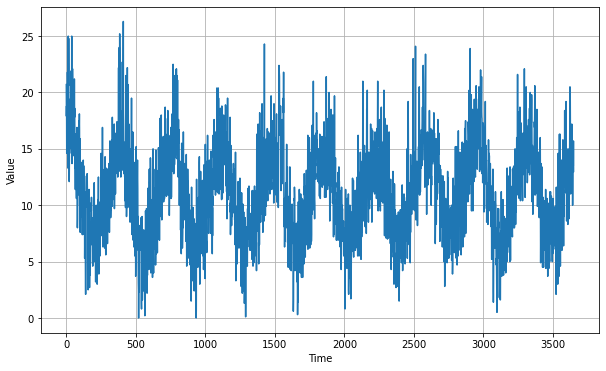

In [7]:
import csv
time_step = []
temps = []

with open('/tmp/daily-min-temperatures.csv') as csvfile:
# YOUR CODE HERE. READ TEMPERATURES INTO TEMPS
# HAVE TIME STEPS BE A SIMPLE ARRAY OF 1, 2, 3, 4 etc
  reader = csv.reader(csvfile)
  next(reader)
  step = 0
  for row in reader:
    temps.append(float(row[1]))
    time_step.append(step)
    step += 1

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [0]:
split_time = 2500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    dataset = tf.data.Dataset.from_tensor_slices(series)

    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda w: w.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda w: (w[:-1], w[1:]))

    return dataset.batch(batch_size).prefetch(1)

In [0]:
def model_forecast(model, series, window_size):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda w: w.batch(window_size))

    dataset = dataset.batch(32).prefetch(1)
    return model.predict(dataset)

In [11]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

window_size = 64
batch_size = 256

train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)


In [12]:
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Lambda
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import Huber

model = tf.keras.models.Sequential([
  Conv1D(filters=32, kernel_size=5, strides=1, padding='causal',
         activation='relu', input_shape=[None, 1]),
  LSTM(units=64, return_sequences=True),
  LSTM(units=64, return_sequences=True),
  Dense(units=32, activation='relu'),
  Dense(units=16, activation='relu'),
  Dense(units=1),
  Lambda(lambda x: x * 400)
])

lr_schedule = LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = SGD(lr=1e-8, momentum=0.9)

model.compile(loss=Huber(), optimizer=optimizer, metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
10/10 [==============================] - 0s 27ms/step - loss: 26.9298 - mae: 27.5022 - lr: 1.0000e-08
Epoch 2/100
10/10 [==============================] - 0s 23ms/step - loss: 26.5813 - mae: 27.0557 - lr: 1.1220e-08
Epoch 3/100
10/10 [==============================] - 0s 23ms/step - loss: 25.9276 - mae: 26.4238 - lr: 1.2589e-08
Epoch 4/100
10/10 [==============================] - 0s 23ms/step - loss: 25.0233 - mae: 25.7051 - lr: 1.4125e-08
Epoch 5/100
10/10 [==============================] - 0s 24ms/step - loss: 24.3287 - mae: 24.9132 - lr: 1.5849e-08
Epoch 6/100
10/10 [==============================] - 0s 23ms/step - loss: 23.4414 - mae: 24.0577 - lr: 1.7783e-08
Epoch 7/100
10/10 [==============================] - 0s 24ms/step - loss: 22.5931 - mae: 23.1408 - lr: 1.9953e-08
Epoch 8/100
10/10 [==============================] - 0s 24ms/step - loss: 21.6610 - mae: 22.1743 - lr: 2.2387e-08
Epoch 9/100
10/10 [==============================] - 0s 26ms/step - loss: 20.6938 - mae:

(1e-08, 0.0001, 0.0, 60.0)

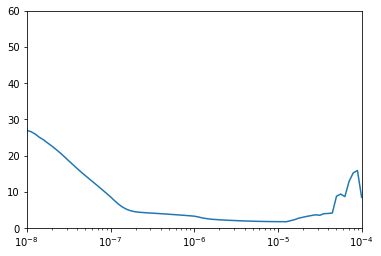

In [13]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)

In [15]:
model = tf.keras.models.Sequential([
  Conv1D(filters=32, kernel_size=5, strides=1, padding='causal',
         activation='relu', input_shape=[None, 1]),
  LSTM(units=64, return_sequences=True),
  LSTM(units=64, return_sequences=True),
  Dense(units=32, activation='relu'),
  Dense(units=16, activation='relu'),
  Dense(units=1),
  Lambda(lambda x: x * 400)
])

optimizer = SGD(lr=1e-5, momentum=0.9)
model.compile(loss=Huber(),  optimizer=optimizer, metrics=["mae"])
history = model.fit(train_set,epochs=100)
                                    
# EXPECTED OUTPUT SHOULD SEE AN MAE OF <2 WITHIN ABOUT 30 EPOCHS

Epoch 1/100
25/25 [==============================] - 0s 15ms/step - loss: 7.9699 - mae: 8.5901
Epoch 2/100
25/25 [==============================] - 0s 15ms/step - loss: 2.5999 - mae: 3.0616
Epoch 3/100
25/25 [==============================] - 0s 15ms/step - loss: 1.9734 - mae: 2.4310
Epoch 4/100
25/25 [==============================] - 0s 15ms/step - loss: 1.7753 - mae: 2.2262
Epoch 5/100
25/25 [==============================] - 0s 14ms/step - loss: 1.7100 - mae: 2.1596
Epoch 6/100
25/25 [==============================] - 0s 14ms/step - loss: 1.6855 - mae: 2.1348
Epoch 7/100
25/25 [==============================] - 0s 13ms/step - loss: 1.6606 - mae: 2.1097
Epoch 8/100
25/25 [==============================] - 0s 14ms/step - loss: 1.6387 - mae: 2.0884
Epoch 9/100
25/25 [==============================] - 0s 13ms/step - loss: 1.6636 - mae: 2.1142
Epoch 10/100
25/25 [==============================] - 0s 14ms/step - loss: 1.6121 - mae: 2.0596
Epoch 11/100
25/25 [=============================

In [0]:
from tensorflow.keras.metrics import mean_absolute_error

rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]
mae = mean_absolute_error(x_valid, rnn_forecast).numpy()

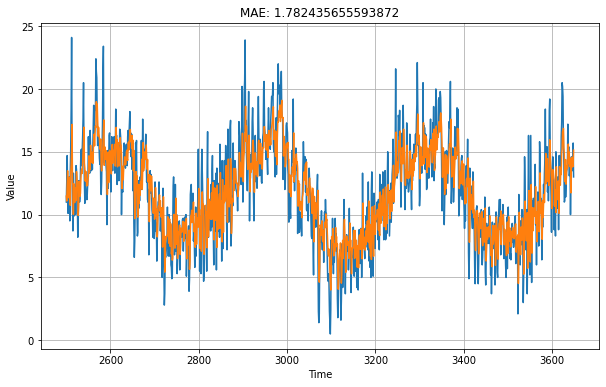

In [17]:
plt.figure(figsize=(10, 6))
plt.title(f'MAE: {mae}')
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

# EXPECTED OUTPUT. PLOT SHOULD SHOW PROJECTIONS FOLLOWING ORIGINAL DATA CLOSELY
# EXPECTED OUTPUT MAE < 2

In [18]:
print(rnn_forecast)
# EXPECTED OUTPUT -- ARRAY OF VALUES IN THE LOW TEENS

[11.471038 11.080192 12.474314 ... 13.932411 13.829458 15.12963 ]
